Let's start here! If you can directly link to an image relevant to your notebook, such as [canonical logos](https://github.com/numpy/numpy/blob/main/doc/source/_static/numpylogo.svg), do so here at the top of your notebook. You can do this with Markdown syntax,

> `![<image title>](http://link.com/to/image.png "image alt text")`

or edit this cell to see raw HTML `img` demonstration. This is preferred if you need to shrink your embedded image. **Either way be sure to include `alt` text for any embedded images to make your content more accessible.**

<img src="images/ProjectPythia_Logo_Final-01-Blue.svg" width=250 alt="Project Pythia Logo"></img>

# Project Pythia Notebook Template

Next, title your notebook appropriately with a top-level Markdown header, `#`. Do not use this level header anywhere else in the notebook. Our book build process will use this title in the navbar, table of contents, etc. Keep it short, keep it descriptive. Follow this with a `---` cell to visually distinguish the transition to the prerequisites section.

---

## Overview
If you have an introductory paragraph, lead with it here! Keep it short and tied to your material, then be sure to continue into the required list of topics below,

1. This is a numbered list of the specific topics
1. These should map approximately to your main sections of content
1. Or each second-level, `##`, header in your notebook
1. Keep the size and scope of your notebook in check
1. And be sure to let the reader know up front the important concepts they'll be leaving with

## Prerequisites
This section was inspired by [this template](https://github.com/alan-turing-institute/the-turing-way/blob/master/book/templates/chapter-template/chapter-landing-page.md) of the wonderful [The Turing Way](https://the-turing-way.netlify.app) Jupyter Book.

Following your overview, tell your reader what concepts, packages, or other background information they'll **need** before learning your material. Tie this explicitly with links to other pages here in Foundations or to relevant external resources. Remove this body text, then populate the Markdown table, denoted in this cell with `|` vertical brackets, below, and fill out the information following. In this table, lay out prerequisite concepts by explicitly linking to other Foundations material or external resources, or describe generally helpful concepts.

Label the importance of each concept explicitly as **helpful/necessary**.

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
| Project management | Helpful | |

- **Time to learn**: estimate in minutes. For a rough idea, use 5 mins per subsection, 10 if longer; add these up for a total. Safer to round up and overestimate.
- **System requirements**:
    - Populate with any system, version, or non-Python software requirements if necessary
    - Otherwise use the concepts table above and the Imports section below to describe required packages as necessary
    - If no extra requirements, remove the **System requirements** point altogether

---

## Imports
Begin your body of content with another `---` divider before continuing into this section, then remove this body text and populate the following code cell with all necessary Python imports **up-front**:

In [3]:
# Import packages
import numpy as np
import pandas as pd
from scipy import interpolate
import scipy
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
import requests
import time
import os
import urllib3
import shutil
import plotly.graph_objs as go
import gsw

import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features
from cmocean import cm as cmo
import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib.patches as patch

# pip install matplotlib-label-lines
# from labellines import labelLine, labelLines
# Modules
# import mod_main as sg
# import mod_L3proc as gproc     # for L3 grid processing
# import mod_DFproc as dfproc    # for dataframe processing
# import mod_plot as sgplot  

from argopy import DataFetcher  # This is the class to work with Argo data
from argopy import ArgoIndex  #  This is the class to work with Argo index
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with usefull pre-defined colors
from argopy.plot import scatter_map, scatter_plot  # This is a function to easily make maps 

# Make a fresh start
import argopy
argopy.reset_options()
argopy.clear_cache()
argopy.set_options(cachedir='cache_bgc')
xr.set_options(display_expand_attrs = False)


import logging
logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("pyproj").setLevel(logging.ERROR)
logging.getLogger("fsspec").setLevel(logging.ERROR)
logging.getLogger("parso").setLevel(logging.ERROR)
logging.getLogger("asyncio").setLevel(logging.ERROR)
DEBUGFORMATTER = '%(asctime)s [%(levelname)s] [%(name)s] %(filename)s:%(lineno)d: %(message)s'
logging.basicConfig(
    level=logging.DEBUG,
    format=DEBUGFORMATTER,
    datefmt='%I:%M:%S %p',
    handlers=[logging.FileHandler("nb-docs.log", mode='w')]
    )

In [189]:

from scipy.stats import kde
from scipy.stats import iqr
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

# Plotting Packages
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import matplotlib.colors as mpcolors
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patheffects as pe
import seaborn as sns

## Introduction: Random Forest Regression

Random Forest (RF) regression is a supervised machine learning method that averages the results over a "forest" of $n$ decision trees for final prediction. Each decision tree determines a series of conditions at each node based on a set of observed variables, referred to as features. For regression, the trees find conditions that best separate the target observations into branches with the least variance. 

Formally, observations are sorted into $j$ regions of predictor space ($R_j$) during training. Following the notation in James et al. (2013), each node in the tree considers a split into two new regions based on a condition $s$ for a predictor $X_j$:
\begin{equation}
\begin{split}
R_1(j,s) = \{X|X_j < s\} \text{ and } R_2(j,s) = \{X|X_j \ge s\}, \\
\end{split}
\end{equation}
and each region is assigned a prediction value that is the average of all target variable values ($\hat{y}_{R_j}$ ) within $R_j$. The condition $s$ is chosen to minimize the residual sum of squares in the resulting bins:
\begin{equation}
\begin{split}
\sum_{i: \: x_i \in \: R_1(j,s)}{} (y_i-\hat{y}_{R_1})^2 \; + \sum_{i: \: x_i \in \: R_2(j,s)}{} (y_i-\hat{y}_{R_2})^2,
\end{split}
\end{equation}
where $y_i$ represents each observed value. During testing, validation, and prediction, RF sorts input observations into the regions and assigns them the value $\hat{y}_{R_j}$. One advantage of RF is that it limits the decision at each node split to a random subset of features. As a result, the trees in Random Forest are less correlated than those in a family of ``bagged'' trees which consider all possible features at all nodes. The RF method is therefore less prone to overfitting, especially on spatiotemporally biased data (Stock et.al (2022), Sharp et al. 2022). 

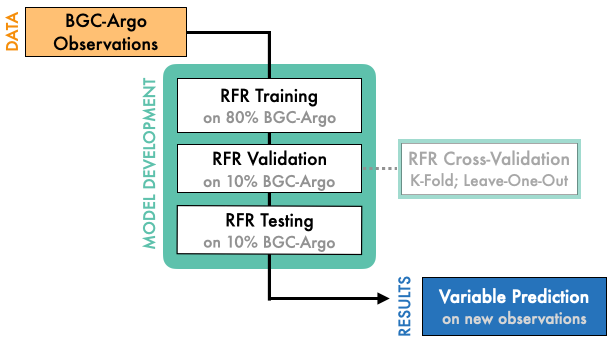

In [195]:
from IPython.display import Image
Image(filename='../images/rfr_workflow.png') 

*Objectives:*

- Train RFR on data from BGC-Argo ocean autonomous profilers and GO-SHIP bottle data
- Validate RFR to select the best model parameters, use cross-validation to assess overfitting
- Test RFR for an estimate of prediction error
- Predict missing variable on other profiling observations


## 1. Load Argo data

We will use Argopy to set up some data to run RFR.

https://nbviewer.org/github/euroargodev/argopy/blob/master/docs/examples/BGC_region_float_data.ipynb

In [27]:
# Format: [lon_min, lon_max, lat_min, lat_max, pres_min, pres_max, datim_min, datim_max]
# BOX = [-56, -45, 54, 60, 0, 2000, '2022-01', '2023-01']
# BOX = [-56, -45, 54, 60, 0, 2000, '2022-09', '2023-01']
BOX = [-56, -45, 54, 60, 0, 500, '2019-01', '2023-01']
# BOX = [-75, -62, 38, 42, 0, 2000, '2021-01', '2022-01']


In [28]:
# Load the BGC-synthetic profiles index
# rq: we work with synthetic profiles because that's the only dataset available from the erddap at this point (2023/07/21)
idx = ArgoIndex(index_file='bgc-s').load()  
idx

<argoindex.pandas>
Host: https://data-argo.ifremer.fr
Index: argo_synthetic-profile_index.txt
Convention: argo_synthetic-profile_index (Synthetic-Profile directory file of the Argo GDAC)
Loaded: True (314253 records)
Searched: False

In [30]:
# Select profile in a space/time domain:
index_BOX = [BOX[ii] for ii in [0, 1, 2, 3, 6, 7]]  # We don't want the pressure axis BOX limits
idx.search_lat_lon_tim(index_BOX)
# Get the list of all parameters for this region:
idx.read_params()

['BBP700',
 'CDOM',
 'CHLA',
 'CHLA_FLUORESCENCE',
 'CP660',
 'DOWNWELLING_PAR',
 'DOWN_IRRADIANCE380',
 'DOWN_IRRADIANCE412',
 'DOWN_IRRADIANCE490',
 'DOXY',
 'NITRATE',
 'PH_IN_SITU_TOTAL',
 'PRES',
 'PSAL',
 'TEMP']

In [31]:
len(idx.read_wmo())

51

In [32]:
f = DataFetcher(ds='bgc', mode='expert', params='all',
                parallel=True, progress=True, cache=False,
                chunks_maxsize={'time': 30},
               )
f = f.region(BOX).load()
f

Final post-processing of the merged dataset () ...


/opt/homebrew/Caskroom/mambaforge/base/envs/sklearn-argo-dev/lib/python3.9/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())


<datafetcher.erddap>
Name: Ifremer erddap Argo BGC data fetcher for a space/time region
API: https://erddap.ifremer.fr/erddap
Domain: [x=-56.00/-45.00; y=54.00/60.0 ... 00.0; t=2019-01-01/2023-01-01]
BGC variables: ['BBP700', 'CDOM', 'CHLA', 'CP660', 'DOWNWELLING_PAR', 'DOWN_IRRADIANCE380', 'DOWN_IRRADIANCE412', 'DOWN_IRRADIANCE490', 'DOXY', 'NITRATE', 'PH_IN_SITU_TOTAL', 'PRES', 'PSAL', 'TEMP']
BGC 'must be measured' variables: []
Performances: cache=False, parallel=True
User mode: expert
Dataset: bgc

In [104]:
# Check the data structure (xarray.dataset):
ds = f.data # Dataset
df = f.index # Dataframe index

ds

<xarray.Dataset> Size: 52MB
Dimensions:                          (N_POINTS: 220652)
Coordinates:
    LATITUDE                         (N_POINTS) float64 2MB 56.93 ... 59.98
    LONGITUDE                        (N_POINTS) float64 2MB -52.52 ... -55.6
    TIME                             (N_POINTS) datetime64[ns] 2MB 2019-01-01...
  * N_POINTS                         (N_POINTS) int64 2MB 0 1 2 ... 11946 11947
Data variables: (12/36)
    CONFIG_MISSION_NUMBER            (N_POINTS) int64 2MB 2 2 2 2 2 ... 3 3 3 3
    CYCLE_NUMBER                     (N_POINTS) int64 2MB 30 30 30 ... 36 36 36
    DIRECTION                        (N_POINTS) <U1 883kB 'A' 'A' ... 'A' 'A'
    DOXY                             (N_POINTS) float32 883kB 295.8 ... nan
    DOXY_ADJUSTED                    (N_POINTS) float32 883kB 313.0 ... nan
    DOXY_ADJUSTED_ERROR              (N_POINTS) float32 883kB 4.457 ... nan
    ...                               ...
    TEMP_ADJUSTED                    (N_POINTS) float32 883kB 3.108 ... 3.485
    TEMP_ADJUSTED_ERROR              (N_POINTS) float32 883kB 0.002 ... 0.002
    TEMP_ADJUSTED_QC                 (N_POINTS) int64 2MB 1 1 1 1 1 ... 8 1 8 1
    TEMP_DATA_MODE                   (N_POINTS) <U1 883kB 'D' 'D' 'D' ... '' ''
    TEMP_QC                          (N_POINTS) int64 2MB 1 1 1 1 1 ... 8 1 8 1
    TIME_QC                          (N_POINTS) int64 2MB 1 1 1 1 1 ... 1 1 1 1
Attributes: (7)

In [259]:
scatter_map?

Signature:
scatter_map(
    data: Union[xarray.core.dataset.Dataset, pandas.core.frame.DataFrame],
    x: str = None,
    y: str = None,
    hue: str = None,
    markersize: int = 36,
    markeredgesize: float = 0.5,
    markeredgecolor: str = 'default',
    cmap: str = None,
    traj: bool = True,
    traj_axis: str = None,
    traj_color: str = 'default',
    legend: bool = True,
    legend_title: str = 'default',
    legend_location: Union[str, int] = 0,
    cbar: bool = False,
    cbarlabels: Union[str, list] = 'auto',
    set_global: bool = False,
    **kwargs,
)
Docstring:
Try-to-be generic function to create a scatter plot on a map from **argopy** :class:`xarray.Dataset` or :class:`pandas.DataFrame` data

Each point is an Argo profile location, colored with a user defined variable and colormap. Floats trajectory can be plotted or not.

Note that all parameters have default values.

Warnings
--------
This function requires `Cartopy <https://scitools.org.uk/cartopy/docs/latest/>`_

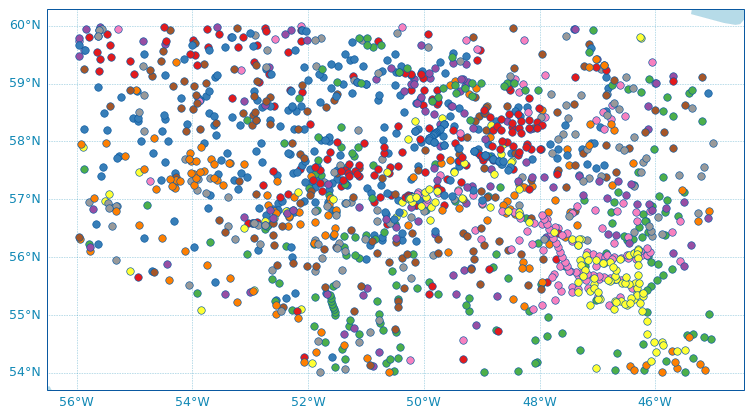

In [262]:
scatter_map(df, traj=False, set_global=False, legend=False);


---

In [276]:
a_param = 'PSAL'
reftbl = ArgoNVSReferenceTables().tbl('R03')
param_info = reftbl[reftbl['altLabel']==a_param].iloc[0].to_dict()
param_info

# To make the scatter map, we need to have the data mode available in one DataFrame column
# so we need to add a new column with the DATA_MODE of the PARAMETER:
df["variables"] = df["parameters"].apply(lambda x: x.split())
df["%s_DM" % a_param] = df.apply(lambda x: x['parameter_data_mode'][x['variables'].index(a_param)] if a_param in x['variables'] else '', axis=1)

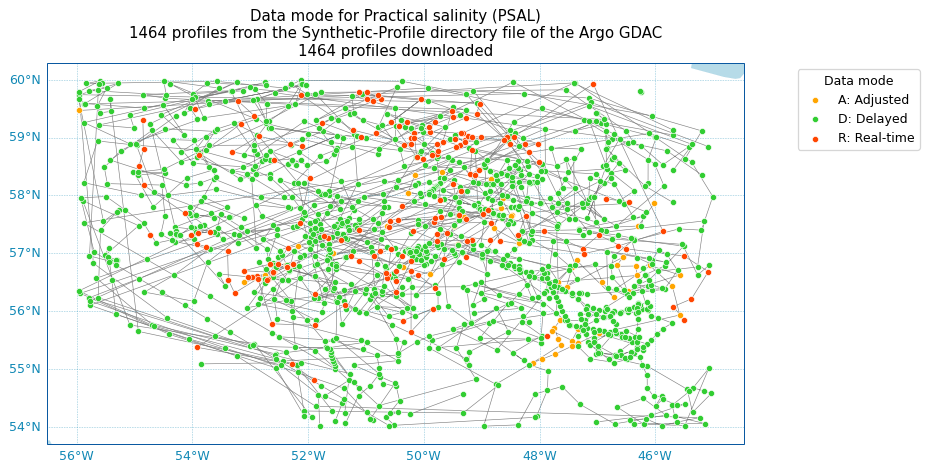

In [277]:
# Finally plot the map:
fig, ax = scatter_map(df,
                        hue="%s_DM" % a_param,
                        cmap="data_mode",
                        markersize=24,
                        markeredgecolor='w',
                        traj_color='gray',
                        legend_title='Data mode')
ax.set_title("Data mode for %s (%s)\n%i profiles from the %s\n%i profiles downloaded" % (param_info['prefLabel'], a_param, 
                                                                           idx.N_MATCH, idx.convention_title, df.shape[0]));

In [ ]:
# Use only delayed mode? 


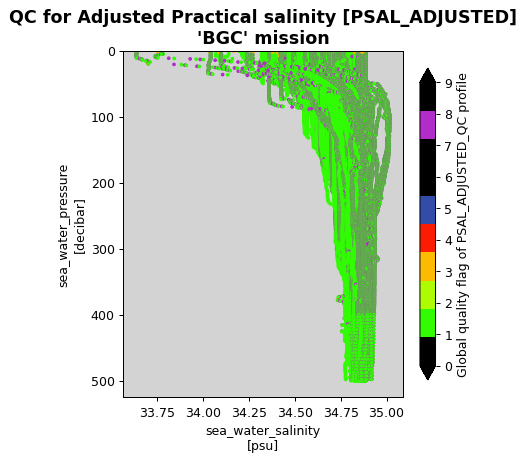

In [279]:
fig, ax = scatter_plot(ds, a_param + '_ADJUSTED_QC', this_x = a_param + '_ADJUSTED', 
                       vmin=0, vmax=9, cmap=ArgoColors('qc').cmap, figsize=(5,5)) #ArgoColors('qc').cmap
ax.set_title("QC for Adjusted %s [%s]\n'%s' mission" % (param_info['prefLabel'], a_param + '_ADJUSTED', f.mission), 
             fontdict={'weight': 'bold', 'size': 14});

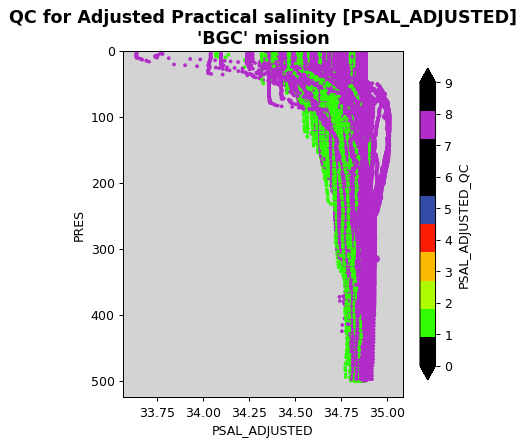

In [280]:
fig, ax = scatter_plot(argodat, a_param + '_ADJUSTED_QC', this_x = a_param + '_ADJUSTED', 
                       vmin=0, vmax=9, cmap=ArgoColors('qc').cmap, figsize=(5,5))
ax.set_title("QC for Adjusted %s [%s]\n'%s' mission" % (param_info['prefLabel'], a_param + '_ADJUSTED', f.mission), 
             fontdict={'weight': 'bold', 'size': 14});

In [87]:
qcvars = ['DOXY_ADJUSTED_QC', 'PSAL_ADJUSTED_QC', 'TEMP_ADJUSTED_QC', 'PRES_ADJUSTED_QC', 'TIME_QC']

In [174]:
# Prepare dataframe before splitting
argodat = ds.argo.point2profile()
argodat = argodat.to_dataframe().reset_index()
argodat.columns

# Run QC
qcvars = ['DOXY_ADJUSTED_QC', 'PSAL_ADJUSTED_QC', 'TEMP_ADJUSTED_QC', 'PRES_ADJUSTED_QC', 'TIME_QC']
print(str(len(argodat)) + ' obs before QC')
X = len(argodat)

for var in qcvars:
    argodat = argodat[(argodat[var] == 1) | (argodat[var] == 2)| (argodat[var] == 8)]
    #qc flag meanings           1: good data, 2: probably good data, 8: interpolated value
    print('after ' + var)
    print('\t' + str(len(argodat)) + ' obs left   ' + ' \t' +str(X-len(argodat)) + ' dropped'); 
    X = len(argodat)

argodat.describe()


/opt/homebrew/Caskroom/mambaforge/base/envs/sklearn-argo-dev/lib/python3.9/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())


560728 obs before QC
after DOXY_ADJUSTED_QC
	99399 obs left    	461329 dropped
after PSAL_ADJUSTED_QC
	98128 obs left    	1271 dropped
after TEMP_ADJUSTED_QC
	98128 obs left    	0 dropped
after PRES_ADJUSTED_QC
	98128 obs left    	0 dropped
after TIME_QC
	98128 obs left    	0 dropped


,N_PROF,N_LEVELS,CONFIG_MISSION_NUMBER,CYCLE_NUMBER,DOXY,DOXY_ADJUSTED,DOXY_ADJUSTED_ERROR,DOXY_ADJUSTED_QC,DOXY_QC,PH_IN_SITU_TOTAL,...,PSAL_QC,TEMP,TEMP_ADJUSTED,TEMP_ADJUSTED_ERROR,TEMP_ADJUSTED_QC,TEMP_QC,TIME_QC,LATITUDE,LONGITUDE,TIME
count,98128.000000,98128.000000,98128.000000,98128.000000,98128.000000,98128.000000,98128.000000,98128.000000,98128.000000,24660.000000,...,98128.000000,98128.000000,98128.000000,98128.000,98128.000000,98128.000000,98128.0,98128.000000,98128.000000,98128
mean,422.690313,326.972108,2.610499,46.101419,276.308441,298.520233,11.049448,1.009916,3.000020,7.989347,...,5.774927,3.923437,3.923435,0.002,6.006033,6.001865,1.0,58.031720,-50.845697,2020-07-26 03:39:14.256888832
min,0.000000,0.000000,1.000000,1.000000,242.795685,267.500732,3.148810,1.000000,3.000000,7.935947,...,1.000000,0.281582,0.281582,0.002,1.000000,1.000000,1.0,54.013050,-55.953330,2019-01-01 06:03:25
25%,396.000000,114.000000,2.000000,13.000000,268.793694,291.590576,8.685021,1.000000,3.000000,7.974373,...,1.000000,3.456667,3.456667,0.002,1.000000,1.000000,1.0,56.964900,-53.113067,2020-02-24 06:08:30
50%,493.000000,249.000000,2.000000,32.000000,275.548965,297.423431,11.988512,1.000000,3.000000,7.983034,...,8.000000,3.669609,3.669609,0.002,8.000000,8.000000,1.0,58.402630,-51.566180,2020-10-11 20:20:37
75%,557.250000,536.000000,3.000000,77.000000,283.566277,305.558212,15.145448,1.000000,3.000000,7.996358,...,8.000000,4.015000,4.015000,0.002,8.000000,8.000000,1.0,59.158047,-47.849660,2021-01-30 23:46:00
max,645.000000,866.000000,4.000000,166.000000,428.659912,465.096008,16.622004,8.000000,4.000000,8.267243,...,8.000000,11.741000,11.741000,0.002,8.000000,8.000000,1.0,59.981862,-45.028000,2021-08-11 20:33:00
std,190.072391,246.138267,0.895818,41.376481,10.263472,10.072508,4.428518,0.263271,0.004515,0.025449,...,3.187838,0.980173,0.980170,0.000,3.159425,3.161376,0.0,1.425728,3.011310,NaN


In [175]:
#  Add training variables 

def datetime2ytd(time, year = 2019):
    """" Return time in YTD format from datetime format."""
    return (time - np.datetime64('2019-01-01'))/np.timedelta64(1, 'D')

argodat['YD'] = datetime2ytd(argodat['TIME'])
argodat['CT'] = gsw.CT_from_t(argodat['PSAL_ADJUSTED'], argodat['TEMP_ADJUSTED'], argodat['PRES_ADJUSTED'])
argodat['SA']= gsw.SA_from_SP(argodat['PSAL_ADJUSTED'],argodat['PRES_ADJUSTED'],argodat['LONGITUDE'],argodat['LATITUDE'])
argodat['SIGMA0'] = gsw.sigma0(argodat.SA.values, argodat.CT.values)
argodat['SPICE'] = gsw.spiciness0(argodat.SA.values, argodat.CT.values)

dvars = ['N_PROF','TIME', 'YD', 'LATITUDE', 'LONGITUDE', 'PRES_ADJUSTED','PSAL_ADJUSTED', 'TEMP_ADJUSTED', 
         'CT', 'SA', 'SIGMA0', 'SPICE', 'DOXY_ADJUSTED']
argo_df = argodat[dvars]

In [176]:
argo_df

,N_PROF,TIME,YD,LATITUDE,LONGITUDE,PRES_ADJUSTED,PSAL_ADJUSTED,TEMP_ADJUSTED,CT,SA,SIGMA0,SPICE,DOXY_ADJUSTED
0,8,2019-01-01 06:03:25,0.252373,56.933030,-52.521630,4.760000,34.624645,3.108200,3.108622,34.788850,27.576438,-0.005224,313.042755
1,8,2019-01-01 06:03:25,0.252373,56.933030,-52.521630,6.280000,34.624847,3.109900,3.110227,34.789055,27.576450,-0.004914,313.051453
2,8,2019-01-01 06:03:25,0.252373,56.933030,-52.521630,8.300000,34.624748,3.110500,3.110705,34.788956,27.576328,-0.004934,313.024292
4,8,2019-01-01 06:03:25,0.252373,56.933030,-52.521630,12.200000,34.624748,3.110800,3.110767,34.788964,27.576328,-0.004922,313.263916
8,8,2019-01-01 06:03:25,0.252373,56.933030,-52.521630,20.259998,34.624855,3.113100,3.112572,34.789096,27.576264,-0.004642,312.554932
...,...,...,...,...,...,...,...,...,...,...,...,...,...
560689,511,2021-08-11 20:33:00,953.856250,59.979127,-55.601015,477.300018,34.836380,3.526123,3.492032,35.003334,27.709688,0.187015,293.204285
560691,511,2021-08-11 20:33:00,953.856250,59.979127,-55.601015,482.300018,34.837322,3.530700,3.496218,35.004287,27.710030,0.188145,293.215576
560693,511,2021-08-11 20:33:00,953.856250,59.979127,-55.601015,487.300018,34.836449,3.520660,3.485872,35.003414,27.710358,0.186400,293.263611
560695,511,2021-08-11 20:33:00,953.856250,59.979127,-55.601015,492.000000,34.834515,3.505021,3.469987,35.001476,27.710384,0.183301,293.467224


## Begin preparing data for training

In [177]:
def split_profiles(floatDF):
    """ 
    @param floatDF: dataframe with all float data

    @return: 
        training_data: training data (80% of profiles) with ship added
        validation_data: validation data (20% of profiles)
    
    This method treats a float profile like the smallest discrete "unit" upon which to train and validate the model.
    Our goal is to predict a water column (profile) rather than a discrete observation, so profiles are kept together while splitting.
    Note that test data will be all profiles from the SOGOS float when test_split is set as False by default.

    """
    # Create list of unique profile ID's and select random 80% for training
    profnum = pd.unique(floatDF.N_PROF)

    np.random.seed(42) 
    training_pnum = np.random.choice(profnum, int(np.floor(0.8*len(profnum))), replace=False)
    training_data = floatDF[floatDF['N_PROF'].isin(training_pnum)]

    # Take HALF of remaining profiles that were not in training set, for validation (10% of total)
    pnum_vt = [x for x in profnum if x not in training_pnum]  # remaining profiles after training data removed

    validation_pnum= np.random.choice(pnum_vt, int(np.floor(0.5*len(pnum_vt))), replace=False)
    validation_data = floatDF[floatDF['N_PROF'].isin(validation_pnum)]

    test_pnum = [x for x in pnum_vt if x not in validation_pnum]
    test_data = floatDF[floatDF['N_PROF'].isin(test_pnum)]

    return training_data, validation_data, test_data

In [178]:
[training, validation, test] = split_profiles(argo_df)

print('# of total profiles: ' + str(len(argo_df.N_PROF.unique())))
print('# training observations: \t' + str(len(training)))
print('# validation observations: \t' + str(len(validation)))
print('# test observations: \t\t' + str(len(test)))

# of total profiles: 480
# training observations: 	77443
# validation observations: 	10341
# test observations: 		10344


In [180]:
training.head()

,N_PROF,TIME,YD,LATITUDE,LONGITUDE,PRES_ADJUSTED,PSAL_ADJUSTED,TEMP_ADJUSTED,CT,SA,SIGMA0,SPICE,DOXY_ADJUSTED
0,8,2019-01-01 06:03:25,0.252373,56.93303,-52.52163,4.760000,34.624645,3.1082,3.108622,34.788850,27.576438,-0.005224,313.042755
1,8,2019-01-01 06:03:25,0.252373,56.93303,-52.52163,6.280000,34.624847,3.1099,3.110227,34.789055,27.576450,-0.004914,313.051453
2,8,2019-01-01 06:03:25,0.252373,56.93303,-52.52163,8.300000,34.624748,3.1105,3.110705,34.788956,27.576328,-0.004934,313.024292
4,8,2019-01-01 06:03:25,0.252373,56.93303,-52.52163,12.200000,34.624748,3.1108,3.110767,34.788964,27.576328,-0.004922,313.263916
8,8,2019-01-01 06:03:25,0.252373,56.93303,-52.52163,20.259998,34.624855,3.1131,3.112572,34.789096,27.576264,-0.004642,312.554932


Try three different models to predict oxygen. 

In [186]:
var_list = {
            'Model_A': ['SPICE', 'SIGMA0'],
            'Model_B': ['CT', 'SA', 'PRES_ADJUSTED'], 
            'Model_C': ["CT", "SA", 'PRES_ADJUSTED', 'YD', 'LATITUDE', 'LONGITUDE'],
            }

model_list = list(var_list.keys())

# Create dictionary of features
allvars = []
for k in var_list.keys():
    allvars = allvars + var_list[str(k)]
allvars = list(set(allvars)) # remove duplicates

In [188]:
pal = sns.color_palette('Set2', n_colors = len(model_list))
model_palettes = {k:v for k, v in zip(model_list, pal)}

In [191]:
var_predict = 'DOXY_ADJUSTED'
def train_RFR(var_list, training, validation, test, ntrees=1000, max_feats = 1/3, min_samples_split=5):
    """ 
    Main method to train the RF model.
    Update 04.18.24: Redo bootstrapping. 
    @param: 
        var_list: list of variables to use in the model
        training: training data unscaled, i.e. original range of values
        validation: validation data unscaled
        test: test data unscaled 
        ntrees: 1000 trees by default.

    @return:
        Mdl: trained RF model
        Mdl_MAE: Rescaled mean absolute error for training, validation, and test sets
        Mdl_IQR: Rescaled IQR for training, validation, and test sets
        DF_with_error: Dataframe with error metrics for the *TEST* set
        validation_error: Dataframe with error metrics for the *VALIDATION* set
    """

    Mdl = RandomForestRegressor(ntrees, max_features = max_feats, random_state = 0, bootstrap=True, min_samples_split=min_samples_split)
        #  max_features: use at most X features at each split (m~sqrt(total features))

    # Drop NaN's without profid or wmoid
    cols_na = [col for col in training.columns if col not in ['profid', 'wmoid', 'AOU', 'dist_maxb']]
    training_nona = training.dropna(axis=0, subset=cols_na)  # makes same length as training_scaled
    validation_nona = validation.dropna(axis=0, subset=cols_na)
    test_nona = test.dropna(axis=0, subset=cols_na)

    # Create X Variables for each subset of data. Scale down. 
    X_training = training_nona[var_list].to_numpy()
    X_validation = validation_nona[var_list].to_numpy()
    X_test = test_nona[var_list].to_numpy()

    # Nitrate, the target variable. 
    Y_training = training_nona[var_predict].to_numpy()
    Y_validation = validation_nona[var_predict].to_numpy()
    Y_test = test_nona[var_predict].to_numpy()

    # Train the model
    Mdl.fit(X_training, Y_training)

    # Estimate
    Y_pred_training = Mdl.predict(X_training)
    Y_pred_validation = Mdl.predict(X_validation)
    Y_pred_test = Mdl.predict(X_test)

    # Create dataframe for the test set with depth --> 
    DF_with_error = test_nona.copy(); 
    DF_with_error = DF_with_error.reset_index(drop=True)
    observed_nitrate = DF_with_error[var_predict].to_numpy()

    # Save new dataframe with test results
    DF_with_error['test_prediction'] = Y_pred_test
    DF_with_error['test_error'] = DF_with_error['test_prediction'] - observed_nitrate
    DF_with_error['test_relative_error'] = DF_with_error['test_error']/observed_nitrate

    # Error metrics
    AE_RF_training = np.abs(Y_pred_training - training_nona[var_predict])
    IQR_RF_training = iqr(abs(AE_RF_training))
    r2_RF_training = r2_score(training_nona[var_predict], Y_pred_training)

    # Return validation metrics
    AE_RF_validation = np.abs(Y_pred_validation - validation_nona[var_predict])
    IQR_RF_validation = iqr(abs(AE_RF_validation))
    r2_RF_validation = r2_score(validation_nona[var_predict], Y_pred_validation)

    validation_error = validation_nona.copy() #pd.DataFrame()
    validation_error['val_error'] = Y_pred_validation - validation_nona[var_predict]
    validation_error['val_relative_error'] = validation_error['val_error']/validation_nona[var_predict]

    AE_RF_test = np.abs(Y_pred_test - test_nona[var_predict]) # same as DF_with_error['test_error']
    IQR_RF_test = iqr(abs(AE_RF_test))
    r2_RF_test = r2_score(test_nona[var_predict], Y_pred_test)

    Mdl_MAE = [np.nanmedian(abs(AE_RF_training)), np.nanmedian(abs(AE_RF_validation)), np.nanmedian(abs(AE_RF_test))]
    Mdl_IQR = [IQR_RF_training, IQR_RF_validation, IQR_RF_test]
    Mdl_r2 = [r2_RF_training, r2_RF_validation, r2_RF_test]

    return [Mdl, Mdl_MAE, Mdl_IQR, Mdl_r2, DF_with_error, validation_error]

In [192]:
from tqdm import tqdm
from importlib import reload

In [193]:
# Train the models with chosen lists.
# Set parameters

models = dict.fromkeys(model_list)
models_MAE = dict.fromkeys(model_list)
models_IQR = dict.fromkeys(model_list)
models_r2 = dict.fromkeys(model_list)
models_DF_err = dict.fromkeys(model_list)
models_val_err = dict.fromkeys(model_list)


ntrees=1000
max_feats = 1/3
min_samples_split = 5
description = 'ntrees=' + str(ntrees) + ', max_features=' + str(max_feats)

print(description + '\n')
for k in tqdm(model_list): # ['Model_G']): 
    [models[k], models_MAE[k], models_IQR[k], models_r2[k], models_DF_err[k], models_val_err[k]] = train_RFR(var_list[k], training, validation, test, 
                                                                                         ntrees = ntrees, max_feats = max_feats,
                                                                                         min_samples_split=min_samples_split)

ntrees=1000, max_features=0.3333333333333333



100%|██████████| 3/3 [04:59<00:00, 99.75s/it] 


In [223]:
RFR_results = [models, models_MAE, models_IQR, models_r2, models_DF_err, models_val_err]

### Feature Importance

In [211]:
allvars = ['SPICE', 'SIGMA0', 'CT', 'SA', 'PRES_ADJUSTED', 'YD', 'LATITUDE', 'LONGITUDE']

In [212]:
# Make total feature importance dictionary for plotting
dict = dict.fromkeys(allvars)
feat_imps = pd.DataFrame()

# Fill in feature importance
for ind, vkey in enumerate(model_list):
    for var in var_list[vkey]:
        feat_imps.at[ind, var] = models[vkey].feature_importances_[var_list[vkey].index(var)]

# feat_imps = feat_imps.set_index('Mdl').fillna(np.nan)
feat_imps['Mdl'] = model_list
feat_imps = feat_imps.set_index('Mdl').fillna(np.nan)
feat_imps

,SPICE,SIGMA0,CT,SA,PRES_ADJUSTED,YD,LATITUDE,LONGITUDE
Mdl,,,,,,,,
Model_A,0.670032,0.329968,NaN,NaN,NaN,NaN,NaN,NaN
Model_B,NaN,NaN,0.369874,0.369655,0.260471,NaN,NaN,NaN
Model_C,NaN,NaN,0.193695,0.265994,0.145652,0.170462,0.119056,0.105142


In [213]:
pal = sns.color_palette('Set2', n_colors = len(model_list))
model_palettes = {k:v for k, v in zip(model_list, pal)}

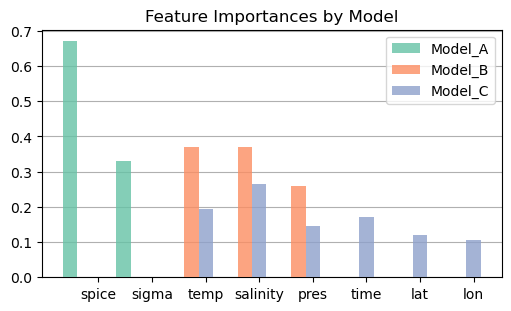

In [282]:
fig = plt.figure(figsize=(5,3), layout='constrained')
ax = fig.gca()

barwidth=.8

modlist = model_list
varslist = allvars
xlabel = ['spice', 'sigma', 'temp', 'salinity', 'pres', 'time', 'lat', 'lon']

# Result of plot method
xind = dict.fromkeys(modlist)
xind[modlist[0]] = np.arange(len(varslist))*len(modlist)

for i in range(len(modlist)-1):
    xind[modlist[i+1]] = [x + barwidth for x in xind[modlist[i]]]

for modtag in modlist:
    ax.bar(xind[modtag], feat_imps[varslist].loc[modtag].to_numpy(), color = model_palettes[modtag], alpha=0.8, label = modtag, zorder=3)

ax.grid(axis='y', zorder=0)
ax.legend(loc='upper right')

ax.set_title('Feature Importances by Model')
ax.set_xticks(xind[modlist[2]])
ax.set_xticklabels(varslist)
ax.set_xticklabels(xlabel);

## Error Analysis

In [225]:
def get_model_metrics(resultlist, mod_list=model_list):
    """ 
    resultlist: typically list of [models, models_MAE, models_IQR, models_r2, models_DF_err]"""
    models_MAE=resultlist[1]
    models_IQR=resultlist[2]
    models_r2=resultlist[3]

    model_metrics = pd.DataFrame()
    model_metrics['validation_MAE'] = [x[1][1].item() for x in models_MAE.items()]
    model_metrics['validation_IQR'] = [x[1][1].item() for x in models_IQR.items()]

    model_metrics['test_MAE'] = [x[1][2].item() for x in models_MAE.items()]
    model_metrics['test_IQR'] = [x[1][2].item() for x in models_IQR.items()]

    model_metrics['model'] = mod_list
    model_metrics.set_index('model', inplace=True)
    
    return model_metrics

# Method to print MAE dictionaries
def print_dict(dict):
    print("\n".join("{}  \t{}".format(k, v) for k, v in dict.items()))

def print_sorted(dict):
    print("\n".join("{}  \t{}".format(k, v) for k, v in sorted(dict.items(), key=lambda x:x[1]))) 

In [229]:
model_metrics = get_model_metrics(RFR_results, mod_list = RFR_results[1].keys()).sort_values(by='validation_MAE')
model_metrics.sort_values(by='validation_MAE', ascending=False)

,validation_MAE,validation_IQR,test_MAE,test_IQR
model,,,,
Model_A,4.141093,5.708864,4.325302,6.878760
Model_B,3.467907,4.921666,3.733346,6.174708
Model_C,1.726600,2.637631,1.840556,3.224108


In [235]:
# Error printing methods
def get_95_bounds(data):
    mean = np.mean(data); std_dev = np.std(data)
    low = mean - 2 * std_dev
    high = mean + 2 * std_dev

    return [low, high]

# Method to print errors restricted to depth 
def print_error_depths(data, var='test_error', pres_lim = [0,500]):
   data = data[(data.PRES_ADJUSTED > pres_lim[0]) & (data.PRES_ADJUSTED < pres_lim[1])]
   err = data[var]

   print('Errors between depths ' + str(pres_lim[0]) + ' to ' + str(pres_lim[1]) + ':')
   print('median abs error: \t' + str(np.abs(err).median()))
   print('mean abs error \t\t' + str(np.abs(err).mean()))

   # Bounds 95
   [low, high] = get_95_bounds(err)
   print('\n95% of errors fall between:')
   print(str(low.round(5)) + ' to ' + str(high.round(5)) )

In [244]:
RFR_results[5]['Model_C']

,N_PROF,TIME,YD,LATITUDE,LONGITUDE,PRES_ADJUSTED,PSAL_ADJUSTED,TEMP_ADJUSTED,CT,SA,SIGMA0,SPICE,DOXY_ADJUSTED,val_error,val_relative_error
41670,460,2019-03-04 06:14:30,62.260069,59.134733,-48.514305,3.600000,34.839001,4.133000,4.130818,35.004666,27.645390,0.260162,300.676208,2.113480,0.007029
41672,460,2019-03-04 06:14:30,62.260069,59.134733,-48.514305,4.800000,34.839752,4.133000,4.130727,35.005419,27.645995,0.260686,300.736420,2.027621,0.006742
41674,460,2019-03-04 06:14:30,62.260069,59.134733,-48.514305,5.900000,34.840000,4.132273,4.129921,35.005667,27.646276,0.260767,300.698639,2.052317,0.006825
41676,460,2019-03-04 06:14:30,62.260069,59.134733,-48.514305,7.100000,34.840000,4.132750,4.130314,35.005665,27.646233,0.260812,300.712494,2.036098,0.006771
41678,460,2019-03-04 06:14:30,62.260069,59.134733,-48.514305,8.500000,34.839214,4.133000,4.130475,35.004873,27.645590,0.260269,300.631805,2.132453,0.007093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541871,132,2021-07-11 10:10:04,922.423657,58.268710,-49.478350,480.480011,34.839638,3.584300,3.549680,35.006761,27.706705,0.195745,300.871002,2.141783,0.007119
541873,132,2021-07-11 10:10:04,922.423657,58.268710,-49.478350,484.500000,34.841240,3.592900,3.557932,35.008374,27.707164,0.197792,300.317169,2.531414,0.008429
541876,132,2021-07-11 10:10:04,922.423657,58.268710,-49.478350,490.510010,34.841934,3.597200,3.561767,35.009077,27.707339,0.198710,299.912964,2.878912,0.009599
541878,132,2021-07-11 10:10:04,922.423657,58.268710,-49.478350,494.489990,34.842438,3.597500,3.561771,35.009585,27.707741,0.199070,299.443787,3.237305,0.010811


In [246]:
print('Model_C') # leaf size: 5
print_error_depths(RFR_results[5]['Model_C'], var='val_relative_error', pres_lim = [0,500])

Model_C
Errors between depths 0 to 500:
median abs error: 	0.005856534948315774
mean abs error 		0.008696245606728789

95% of errors fall between:
-0.02874 to 0.02038


In [239]:
RFR_results[4]['Model_C'].test_relative_error.mean()

-0.004749670578420855

Text(0.5, 1.0, 'Validation Error Distributions by Model')

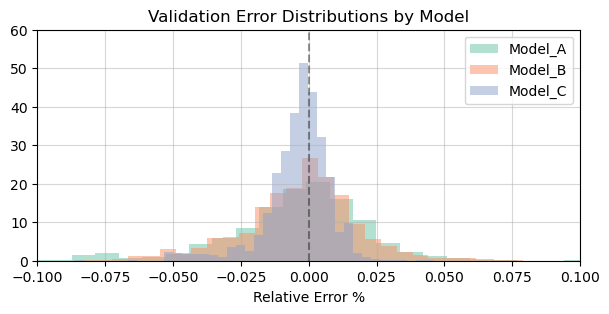

In [281]:
which = 'val'

if which == 'val':
    tag = 'Model Validation Errors'
    var = 'val_relative_error'
    dat = RFR_results[5]
    ymax=60
else:
    tag = 'Model Test Errors'
    var = 'test_relative_error'
    dat = RFR_results[4]
    ymax=52

fig = plt.figure(figsize=(7,3))
ax = fig.gca()

for mod in model_list[-4:]:
    RF = dat[mod][var]
    ax.hist(RF, bins=40, alpha=0.5, color= model_palettes[mod], label=mod, density=True)

ax.vlines(0, ymin=0, ymax=ymax, colors='k', alpha=0.4, linestyles='dashed')
ax.set_ylim([0,ymax])

plt.legend()
ax.set_xlabel('Relative Error %')

ax.grid(alpha=0.5, zorder=0)
ax.set_xlim([-.1, .1])

ax.set_title('Validation Error Distributions by Model')


---

This is where you begin your first section of material, loosely tied to your objectives stated up front. Tie together your notebook as a narrative, with interspersed Markdown text, images, and more as necessary,

In [ ]:
# as well as any and all of your code cells
print("Hello world!")

### A content subsection
Divide and conquer your objectives with Markdown subsections, which will populate the helpful navbar in Jupyter Lab and here on the Jupyter Book!

In [ ]:
# some subsection code
new = "helpful information"

### Another content subsection
Keep up the good work! A note, *try to avoid using code comments as narrative*, and instead let them only exist as brief clarifications where necessary.

## Your second content section
Here we can move on to our second objective, and we can demonstrate

### Subsection to the second section

#### a quick demonstration

##### of further and further

###### header levels

as well $m = a * t / h$ text! Similarly, you have access to other $\LaTeX$ equation [**functionality**](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html) via MathJax (demo below from link),

\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{align}

Check out [**any number of helpful Markdown resources**](https://www.markdownguide.org/basic-syntax/) for further customizing your notebooks and the [**Jupyter docs**](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html) for Jupyter-specific formatting information. Don't hesitate to ask questions if you have problems getting it to look *just right*.

## Last Section

If you're comfortable, and as we briefly used for our embedded logo up top, you can embed raw html into Jupyter Markdown cells (edit to see):

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Your relevant information here!
</div>

Feel free to copy this around and edit or play around with yourself. Some other `admonitions` you can put in:

<div class="admonition alert alert-success">
    <p class="admonition-title" style="font-weight:bold">Success</p>
    We got this done after all!
</div>

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    Be careful!
</div>

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">Danger</p>
    Scary stuff be here.
</div>

We also suggest checking out Jupyter Book's [brief demonstration](https://jupyterbook.org/content/metadata.html#jupyter-cell-tags) on adding cell tags to your cells in Jupyter Notebook, Lab, or manually. Using these cell tags can allow you to [customize](https://jupyterbook.org/interactive/hiding.html) how your code content is displayed and even [demonstrate errors](https://jupyterbook.org/content/execute.html#dealing-with-code-that-raises-errors) without altogether crashing our loyal army of machines!

---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!